In [11]:
import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib.collections import LineCollection

from scipy.fftpack import fft, fftfreq

mpl.rcParams.update({'font.size': 12})

In [12]:
# Final time of the simulation
final_time = 50.

# PDE parameter
Lx = 10.

# If running this with a file...
### Skip to [Loading the Solution](#Load-the-Simulation)

#### Set up PDE

In [13]:
# Define PDE values

# Number of points in the computational grid
Nx = 64

# CFL factor
CFL = 0.001

# PDE Parameters
a = 0.1

In [14]:
# dx and dt
delta_x = Lx / Nx
delta_t = CFL * delta_x**3 / a

print("Delta t = {0:g}, Delta x = {1:g}".format(delta_t, delta_x))

# Create spatial grid
x = np.arange(delta_x / 2. - Lx/2, Lx/2, delta_x)

# Specify the number of time points to store (Nouts)
#  they will be equally spaced throughout the simulation.
Nouts = 200
output_interval = final_time / Nouts
t = np.zeros(Nouts + 1)
t[0] = 0.

# Create an array to store the solution, and write in the initial conditions
solution = np.zeros((Nouts + 1,Nx))
solution[0,:] = np.sin( 4 * np.pi * x / Lx ) + 0.25 * np.sin( 8 * np.pi * x / Lx )
u = solution[0, :]

Delta t = 3.8147e-05, Delta x = 0.15625


#### Plot ICs

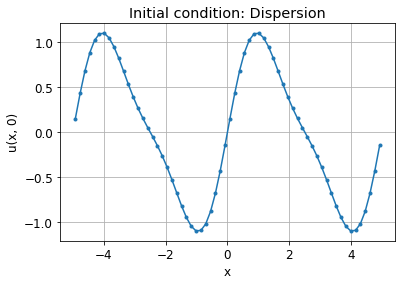

In [15]:
plt.plot( x, u, '.-' )
plt.grid()
plt.xlabel('x')
plt.ylabel('u(x, 0)')
plt.title('Initial condition: Dispersion')
plt.savefig('dispersion_ic_Nx={}.png'.format(Nx))

#### Define Function to Compute Third Derivative

In [16]:
def d3dx3(f, dx = delta_x):
    return  (- 0.5 * np.roll(f, 2) + np.roll(f, 1) - np.roll(f, -1) + 0.5 * np.roll(f, -2)) / ( dx**3 )

## Part (b)

In [17]:
def finite_difference(NModes):
    Lx = 2 * np.pi
    Nxs = np.power(2, np.arange(2, 9))
    
    # Create arrays to store the error values
    err_3 = np.zeros(Nxs.shape)
    
    # Create figure
    fig, ax = plt.subplots(1, 1, figsize = (11, 4))
    
    for ind, Nx in enumerate(Nxs):
        
        # Create grid
        dx = Lx / Nx
        x = np.linspace(0, Lx, Nx + 1)[:-1]
        
        # Function to differentiate
        y = np.sin(NModes * x)
        
        # True derivatives
        dydx3_true = -NModes**3 * np.cos(NModes * x)
        
        # Compute the numerical derivatives
        Ord2 = d3dx3(y, dx = dx)
        
        # Store the error in the numerical derivatives
        err_3[ind] = np.sqrt(np.mean((Ord2 - dydx3_true)**2))
      
    # Plot the numerical errors
    ax.plot(Lx/Nxs, err_3, '-o', label='2nd order (numerical)')
    
    ax.plot(Lx/Nxs, (Lx/Nxs)**2, '--k', label='$dx^2$')
    
    lgd = ax.legend(bbox_to_anchor=(1., 0, 0.25, 1))
    x = ax.set_xlabel('$\Delta x$')
    y = ax.set_ylabel('Finite Difference Error')
    title = ax.set_title('Error vs $\Delta x$: Third Derivative'.format(NModes))
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.grid()
    
    fig.tight_layout()
    fig.savefig('question3b_Nx={}.png'.format(Nx), bbox_extra_artists=(lgd, title, y, x), bbox_inches='tight')
    return fig, ax

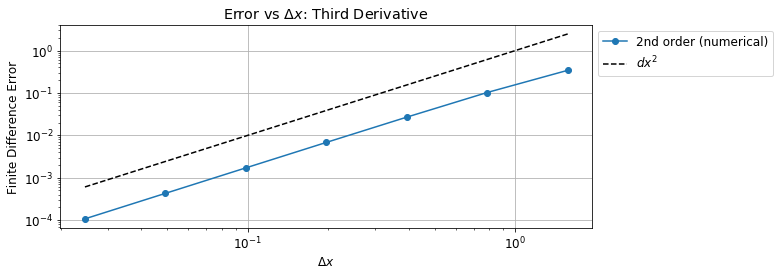

In [18]:
fig, ax = finite_difference(1)

## Part (d): Solve PDE

#### Compute Numerical Solution

In [19]:
curr_time = t[0]
u = solution[0,:]
next_output_time = output_interval
output_number = 0
while curr_time < final_time:
    
    # Compute the RHS of the ODE
    dudt = a * d3dx3( u )
    
    # Update first-order record
    u = u + delta_t * dudt
    
    # Increase 'time' by Delta t
    curr_time = curr_time + delta_t
    
    # Store the new values in our array, if at the right time
    if curr_time >= next_output_time:
        output_number = output_number + 1
        next_output_time += output_interval
        
        solution[output_number,:] = u
        t[output_number] = curr_time
    
# Helps to avoid odd errors from funky step sizes
t = t[:output_number]
solution = solution[:output_number,:]

In [20]:
print( "The stored solution has {0:d} time points and {1:d} space points.".format(*solution.shape) )

The stored solution has 200 time points and 64 space points.


#### Save the Solution

In [21]:
# This will save
#   - solution as 'u'
#   - t as 'time'
#   - x as 'x'
#   - U0 and 'U0'
np.savez('dispersion_data_cfl{0}_Nx{1}.npz'.format(CFL, Nx), 
         u = solution, 
         time = t, 
         x = x, 
         a = a,
         dx = delta_x,
         dt = delta_t)

## Load the Simulation

In [22]:
# Enter the Nx and CFL values
# corresponding to the file you have

Nx = 64
CFL = 0.001

In [23]:
dispersion = np.load('dispersion_data_cfl{0}_Nx{1}.npz'.format(CFL, Nx))

t = dispersion['time']        # The temporal grid
x = dispersion['x']            # The spatial grid
solution = dispersion['u']            # The solution (first axis is time, second is space)
delta_x = dispersion['dx']
delta_t = dispersion['dt']
a = float(dispersion['a'])    # The viscosity coefficient

Nt, Nx = solution.shape

print('The data has {0:d} time points and {1:d} space points.'.format(Nt, Nx))
print('The dispersion coefficient alpha is {0:g}'.format(a))

The data has 200 time points and 64 space points.
The viscous coefficient nu is 0.1


#### Plot the Solution

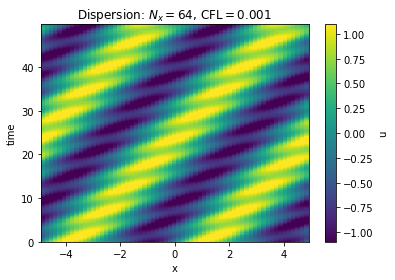

In [7]:
tmax = len(t)
cv = np.max( np.abs( solution[0,:] ) )
plt.pcolormesh( x, t[:tmax], solution[:tmax,:], vmin = -cv, vmax = cv)

cbar = plt.colorbar()
cbar.ax.set_ylabel('u')

plt.xlabel('x')
plt.ylabel('time')
plt.title('Dispersion: $N_x={0}$, CFL$={1}$'.format(Nx, CFL))
plt.savefig('dispersion_3d_Nx={0}_cfl={1}.png'.format(Nx, CFL))

## Part (e)

In [8]:
E = []
for i in range(len(t)):
    E.append(np.sum(solution[i,:]**2 * delta_x))

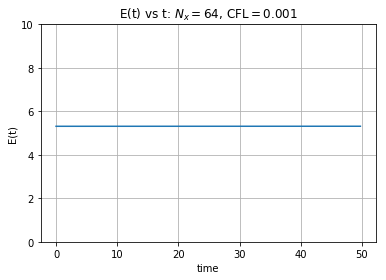

In [9]:
plt.plot(t, E)
plt.xlabel('time')
plt.ylabel('E(t)')
plt.title('E(t) vs t: $N_x={0}$, CFL$={1}$'.format(Nx, CFL))
plt.ylim(0, 10)
plt.grid()
plt.savefig('dispersion_energy_Nx={0}_cfl={1}.png'.format(Nx, CFL))

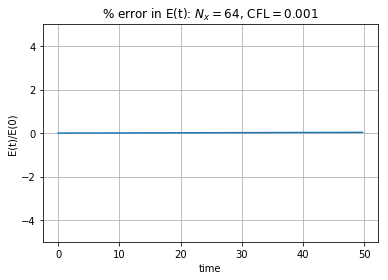

In [10]:
plt.plot(t, (E-E[0])/E[0] * 100)
plt.xlabel('time')
plt.ylabel('E(t)/E(0)')
plt.title('% error in E(t): $N_x={0}$, CFL$={1}$'.format(Nx, CFL))
plt.ylim(-5, 5)
plt.grid()
plt.savefig('dispersion_percent_energy_Nx={0}_cfl={1}.png'.format(Nx, CFL))